## Import Packages

In [1]:
from __future__ import division
import math
import torch
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import load_metr_la_rdata, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,test_error
import random
import pandas as pd
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
import geopandas as gp
import matplotlib as mlt
from numpy import genfromtxt
import scipy
import scipy.sparse as sp
import seaborn as sns
import heapq
import joblib
from geopy.distance import distance as geodist
from sklearn.neighbors import NearestNeighbors
plt.rcParams['figure.figsize'] = (20, 10)

/Users/chetan/opt/anaconda3/envs/KrigingGCN/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

Air Quality Data from Pune City in India: Contains air quality data and composition of various pollutants at different locations.
<br>
Sensor locations data: Contains Latitude, Longitude information, sensor ID, and sensor address.
<br>
Import air quality index time series data (15 min interval data): obtained by performing regression on Pune dataset.
<br>
Boundary map of the city pune.

In [165]:
Aqm_Pune = pd.read_csv('pune-aqm.csv')              # Load Raw AQM Data
Sensor_Location = pd.read_csv('pune_sensor.csv')    # Load Sensor Location Data
#time_series_data = genfromtxt('pune_aqm_2020Oct_2022July_TimeSynched.csv', delimiter=',', skip_header = 1) # Load Time Synchronized AQM Data
time_series_data = genfromtxt('GRIN_Imputed_Pune_Data.csv', delimiter=',', skip_header = 1) # Load GRIN Imputed Data
map_ms=gp.read_file('maharashtra_administrative/maharashtra_administrative.shp',encoding="utf-8")
map_pune = map_ms[map_ms['NAME'] == 'Pune']

### Data Selection

In [166]:
#time_series_data = np.nan_to_num(time_series_data[:,1:])  # Replace NaN with 0's in Time Synchronized Data
time_series_data = time_series_data[2:,1:].T               # Discard Unwanted rows and Columns from the Data
time_series_data

array([[ 4.25    ,  4.25    ,  4.25    , ..., 13.      , 14.      ,
        14.5     ],
       [22.716587, 22.716587, 22.716587, ...,  9.408189,  9.408189,
         9.408189],
       [ 6.727941,  6.727941,  6.727941, ...,  3.      ,  2.      ,
         3.      ],
       ...,
       [18.684256, 18.684256, 18.684256, ...,  4.375   ,  4.375   ,
         0.      ],
       [22.382853, 22.382853, 22.382853, ...,  3.      ,  4.      ,
         3.      ],
       [13.      , 13.      , 13.      , ...,  9.      ,  9.      ,
         9.      ]])

### Order Latitude and Longitude according to the Data

In [167]:
dum = Aqm_Pune.id.unique()    # Get all the sensor ID's
known_latlon = pd.DataFrame(columns = ['latitude', 'longitude'])       # Create an empty DataFrame to store 'known' latitude and longitude

for i in range(len(Sensor_Location)-1):           # Loop over all the sensor loations in the data
    single_sensor_location = Sensor_Location[Sensor_Location['id'] == dum[i]].reset_index(drop=True,inplace=False)   # Get information of a single sensor
    known_latlon.loc[len(known_latlon.index)] = [(single_sensor_location['latitude'].values)[0], (single_sensor_location['longitude'].values)[0]]    # Append dummy data frame to the ordered data frame 
#known_latlon

###### Create a grid of Latitude and Longitudes around existing sensor locations

In [168]:
lat_min = min(known_latlon['latitude']) # Minimum latitude value
lat_max = max(known_latlon['latitude']) # Maximum latitude value
lng_min = min(known_latlon['longitude']) # Minimum longitude value
lng_max = max(known_latlon['longitude']) # Maximum longitude value
ext = 0.01 # Value of extension to the grid
grid_length = 10
xx = np.linspace(lng_min-ext, lng_max+ext, grid_length) # Get 100 longitude values between maximum and minimum longitude values
yy = np.linspace(lat_min-ext, lat_max+ext, grid_length) # Get 100 latitude values between maximum and minimum latitudes values

unknown_set = np.meshgrid(xx, yy) # Get grid with arrays xx and yy
gridx = np.reshape(unknown_set[0], (1, grid_length*grid_length)) # Array of all longitude values in the grid
gridy = np.reshape(unknown_set[1], (1, grid_length*grid_length)) # Array of all latitude values in the grid

gridyx = np.concatenate((gridy.T, gridx.T), axis=1) # Concatenate latitude and longitude arrays

unknown_latlon = pd.DataFrame(columns = ['latitude', 'longitude']) # Define an empty DataFrame for unknown latitude and longitude values
unknown_latlon[['latitude', 'longitude']] = gridyx # Assign Concatenated latitude and longitude array to unknown latitude longitude DataFrame

latlon = pd.concat([known_latlon, unknown_latlon], ignore_index = True) # Concatenate both known and Unknown lat lon DataFrame with new index
#latlon

### Initializations

n_sample $(n_o + n_m)$: is the sampling space dimension for random graph sampling for model traning
<br>
Time Dimension ($h$): is the sampled time dimension or the chosen sliding window lenght for the model learning
<br>
Hiddenn Dimension ($z$): is the number hidden layers for graph convolution (Graph Neural Network)
<br>
order ($K$): Odrder of diffusion convolution, the actual convolution step is $K+1$
<br>
Masked nodes ($n_m$): Number of masked nodes during training
<br>
Target Locations ($N_u$): Locations that will be deleted from training data
<br>
Maximum Episode: Maximum training ietrations (more the iterations better the training model will be)
<br>
learning_rate: the learning rate of the Adam optimizer for weights optimation in GNN
<br>
E_maxvalue: Maximum values from learning experience
<br>
Batch Size (batch_size): Batch size used for model training

In [169]:
n_sample = 39            # sampled space dimension

time_dimension = 8       # h - sampled time dimension (one day data with one sample every 15min)

hidden_dimension = 100   # z - hidden dimension for graph convolution

order = 2                # k - If using diffusion convolution, the actual diffusion convolution step is K+1

n_m = 17                 # number of mask node during training

N_u = 17                 # target locations, N_u locations will be deleted from the training data

Max_episode = 100        # max training episode

learning_rate = 0.0001   # the learning_rate for Adam optimizer

E_maxvalue = 1           # the max value from experience

batch_size = 4

### Building the IGNNK Model

In [170]:
IGNNKmodel = IGNNK(time_dimension, hidden_dimension, order)  # The graph neural networks

### Building Gaussian Adjacency Matrix

$Step\ 1:$ Compute pairwise distacne between the sensor locations
<br>
$Step\ 2:$ Build Gaussian adjacency mactrix $W_{ij}$ using equation:
<br>
$$
W_{ij} = \exp\Big(-\frac{dist(s_i-s_j)^2}{2\sigma^2}\Big)
$$
<br>
where $dist(s_i-s_j)$ is the distance between the geographic loactions $s_i$ and $s_j$.

In [171]:
# Compute pairwise distances between all the sensor locations
pairwise_distance = scipy.spatial.distance.cdist(known_latlon.to_numpy(), known_latlon.to_numpy(), lambda u, v: geodist(u, v).km)
# known_pairwise_distance = scipy.spatial.distance.cdist(known_latlon.to_numpy(), known_latlon.to_numpy(), lambda u, v: geodist(u, v).km)
           

# Choose sigma (standard Deviation of the pairwise distances)
#sigma = np.std(pairwise_distance)
#print(sigma)
sigma = 2 # From above sigma computation (Commented to save running time)

# Compute Adjacency matrix
Wij = np.exp(-0.5*(pairwise_distance**2/sigma**2))
#sigma = np.mean(pairwise_distance)

### Building Gaussian Adjacency Matrix using k-Nearest Neighbours

Consider only k-Nearest Neighbors in the Adjacency Matrix.
<br>
Suppose $\mathcal{N}_i$ represents the k-Nearest Neighborhood to the location $i$. Then, build Gaussian adjacency mactrix $W_{ij}$ using equation:
<br>
$$
W_{ij} = 
\begin{cases}
    \exp\Big(-\frac{dist(s_i-s_j)^2}{2\sigma^2}\Big),& \text{if } s_j \in \mathcal{N}_i\\
    0,& \text{otherwise}
\end{cases}
$$

In [172]:
Wij_k = np.zeros(pairwise_distance.shape)
k = 5   # Number of neighbors considered

for i in range(pairwise_distance.shape[0]):
    arr = pairwise_distance[i]        # Get i'th row in the distance matrix
    indices = np.argsort(arr)[1:k]    # Indices of the k-Nearest Neighbors
    Wij_k[i, indices] = np.exp(-0.5*(arr[indices]/sigma)**2)  # Compute Gaussian Kernel for k-Nearest Neighbors

###### Assign and arrange Time Series data and Adjacency Matrix

In [173]:
#A = Wij 
A = Wij_k  # For k-Nearest Neighbor based kernel
X = time_series_data
X = X[:-1,:]   # Discard last sensor and discard last row in the time series data
#data_scaler = StandardScaler()
#data_scaler.fit(X)
#X = data_scaler.transform(X)

###### Divide known and unknown locations, Get training data and corresponding Adjacency Matrix

In [174]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(known_latlon.to_numpy(), X, np.arange(X.shape[0]), test_size=0.2, random_state=0)

In [175]:
split = int(X.shape[1] * 0.7)
training_set = X[:, :split].T #[:, :split]
test_set = X[:, split:].T                    # split the training and test period
known_set = set(indices_train)                          # Get indices of unknown locations
unknown_set = set(indices_test)                         # Get indices of known locations
training_data = training_set[:,list(known_set)]                                     # Get training data (Available data in this case)
A_known = A[:, list(known_set)][list(known_set), :]     # Get adjacency matrix for known locations from full adjacency matrix

### Train IGNNK Model

In [176]:
criterion = nn.MSELoss()
optimizer = optim.Adam(IGNNKmodel.parameters(), lr=learning_rate)
RMSE_list = []
MAE_list = []
MAPE_list = []
ignnk_predict_list = []
for epoch in range(100):
    for i in range(training_data.shape[0]//(time_dimension * batch_size)):  #using time_length as reference to record test_error
        random_time_index = np.random.randint(0, high=(training_data.shape[0] - time_dimension), size=batch_size, dtype='l')
        known_mask = set(random.sample(range(0,training_data.shape[1]),n_sample)) #sample n_o + n_m nodes
        feed_batch = []
        for j in range(batch_size):
            feed_batch.append(training_data[random_time_index[j]: random_time_index[j] + time_dimension, :][:, list(known_mask)]) #generate 8 time batches
        
        inputs = np.array(feed_batch)
        inputs_omask = np.ones(np.shape(inputs))
        inputs_omask[inputs == 0] = 0           # We found that there are irregular 0 values for METR-LA, so we treat those 0 values as missing data,
                                                # For other datasets, it is not necessary to mask 0 values
        missing_index = np.ones((inputs.shape))
        for j in range(batch_size):
            missing_mask = random.sample(range(0,n_sample),n_m) #Masked locations
            missing_index[j, :, missing_mask] = 0
        Mf_inputs = inputs * inputs_omask * missing_index / E_maxvalue #normalize the value according to experience
        Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32'))
        mask = torch.from_numpy(inputs_omask.astype('float32'))   #The reconstruction errors on irregular 0s are not used for training
        
        A_dynamic = A_known[list(known_mask), :][:, list(known_mask)]   #Obtain the dynamic adjacent matrix
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))
        
        outputs = torch.from_numpy(inputs.astype('float32')/E_maxvalue) #The label
        
        optimizer.zero_grad()
        X_res = IGNNKmodel(Mf_inputs, A_q, A_h)  #Obtain the reconstruction
        loss = criterion(X_res*mask, outputs*mask)
        loss.backward()
        optimizer.step()        #Errors backward
        
    
    
    #estimated_data = np.zeros([training_data.shape[0], len(unknown_set)])
    #training_estimated_data = np.concatenate((training_data, estimated_data), axis = 1)

    #print(training_estimated_data.shape)
    #print(training_data.shape)
    #print(estimated_data.shape)
    MAE_t, RMSE_t, MAPE_t, ignnk_predict  = test_error(IGNNKmodel, unknown_set, test_set, A,E_maxvalue, True)
    RMSE_list.append(RMSE_t)
    MAE_list.append(MAE_t)
    MAPE_list.append(MAPE_t)
    ignnk_predict_list.append(ignnk_predict)
    if epoch%10 == 0:
        print(epoch, MAE_t, RMSE_t, MAPE_t)
idx = MAE_list == min(MAE_list)
print('Best model result:',np.array(MAE_list)[idx],np.array(RMSE_list)[idx],np.array(MAPE_list)[idx])
ignnk_predict_opt = ignnk_predict_list[int(np.where(idx)[0])]

/Users/chetan/opt/anaconda3/envs/KrigingGCN/utils.py:270: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(d, -1).flatten()


0 25.800519755675783 50.69048460179254 0.12184512767356115
10 25.802892746382703 50.11324299327876 0.14173135727483333
20 25.21709486613752 49.421476806515365 0.16526299519803356
30 25.18615101050083 49.320893335344714 0.16865728090837462
40 24.902079649967554 49.2603549407144 0.17069687357701413
50 24.578122449953813 48.81207517287142 0.1857218674698442
60 24.80743420396647 49.28568659176163 0.16984373238807593
70 24.082865826479612 48.193306348430916 0.20623549575169065
80 24.090435317090456 47.86450400325602 0.21702958036676312
90 24.00041698565532 48.352455992540875 0.20098431319149446
Best model result: [23.82855713] [47.80819346] [0.21887076]


### Interpolate PM2.5 at Masked locations

In [178]:
estimated_data = np.zeros([time_series_data.shape[1], len(unknown_set)])
training_estimated_data = np.concatenate((X[list(known_set),:].T, estimated_data), axis = 1)
MAE_t, RMSE_t, MAPE_t, ignnk_predict  = test_error(IGNNKmodel, unknown_set, training_estimated_data, A,E_maxvalue, True)

### Plot RMSE on training set

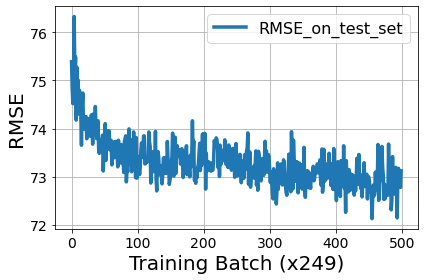

In [138]:
fig,ax = plt.subplots()
ax.plot(RMSE_list,label='RMSE_on_test_set',linewidth=3.5)
ax.set_xlabel('Training Batch (x249)',fontsize=20)
ax.set_ylabel('RMSE',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()

### Initialize variables to get Date-Time object for Sensor Measurements for every 15 min interval

In [136]:
from datetime import datetime, timedelta, timezone
start_date = '2020-10-16 05:30:00'     # Starting date-time for data
#date_format_str = '%Y-%m-%d %H:%M:%S%z'
date_format_str = '%Y-%m-%d %H:%M:%S'  # Date-time format
end_date = '2022-07-20 05:30:00'       # Ending date-time for data
d0 = datetime.strptime(start_date, date_format_str) # Converting starting date-time string to datetime Object
d1 = datetime.strptime(end_date, date_format_str)   # Converting ending date-time string to datetime Object
diff = d1-d0      # Get difference between stating date-time object to ending date-time object
sampling_frequency = 0.25       # Sampling frequency (0.25 = 15min, 0.5 = 30min, 1 = 1hr)
end_slot = start_date           # Initiate ending time slot as the starting time
start_slot = datetime.strptime(start_date, date_format_str) # Initiate starting time slot as the starting time
                                                            # Initially start and end slots are the same (before iteration)

### Get Date-Time object for Sensor Measurements for every 15 min interval

In [137]:
DateTime = start_slot  # Variable to store date-time object data, Initiate DateTime with starting date-time object and store 
for j in range(int(diff.days*24*(1/sampling_frequency))):      # Loop to get date-time objects for sensor data
    end_slot = start_slot+timedelta(hours = sampling_frequency) # Change end_slot for the loop by adding 15 mins to start_slot
    start_slot = end_slot    # Change start_slot for the next loop by assiging end_slot to start_slot
    DateTime = np.append(DateTime, start_slot)  # Append new start_slot (next date-time object) to DateTime variable

### Compare Interpolation results with real data using plots

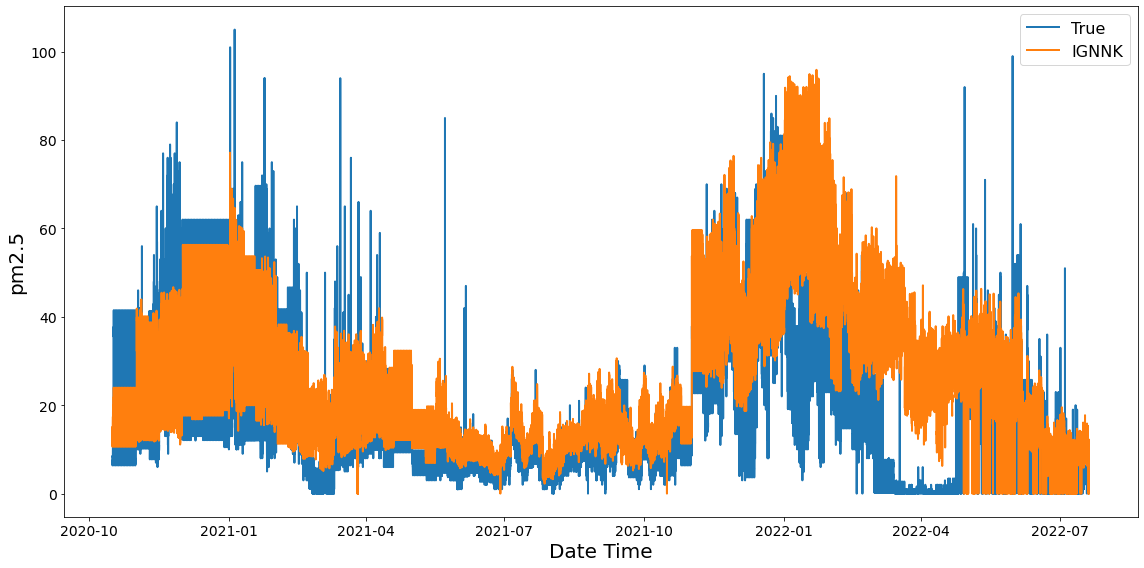

In [210]:
fig,ax = plt.subplots(figsize = (16,8))
station = list(unknown_set)[3]
ax.plot(DateTime[:-1], X[station, :61632],label='True',linewidth=2)
ax.plot(DateTime[:-1], ignnk_predict[:61632,station],label='IGNNK',linewidth = 2)
ax.set_ylabel('pm2.5',fontsize=20)
ax.set_xlabel('Date Time',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(loc='best', fontsize=16)
plt.tight_layout()
#plt.savefig('fig/ignnk_pm2p5.pdf')
plt.show()

### Overall Mean Absolute Error between actual and Interpolated Data

In [204]:
print('Overall Mean Absolute Error is:', mae(ignnk_predict[:61632,:],X[:, :61632].T))

Overall Mean Absolute Error is: 20.630129876253182


### Mean Absolute Error Between Actual and Interpolated Data for Individual Sensors

In [205]:
List = np.sort(indices_test)
MAEs = []
for i in range(10):
    print('MEA for sensor {} is {}'.format( List[i], mae(ignnk_predict[:,List[i]],X[List[i], :])))
    MAEs.append(mae(ignnk_predict[:,List[i]],X[List[i], :]))

MEA for sensor 4 is 14.049481326512733
MEA for sensor 7 is 16.900867925349257
MEA for sensor 10 is 17.417030621831465
MEA for sensor 26 is 24.381716452126597
MEA for sensor 29 is 14.816187851827562
MEA for sensor 30 is 26.31692167158343
MEA for sensor 32 is 22.91585190025183
MEA for sensor 34 is 9.661776141449419
MEA for sensor 37 is 10.485911761260747
MEA for sensor 40 is 50.40397326206729
